Theodoros Kassa Aragie

251163893

ECE 9309

Prof. Soodeh Nikan

February 17, 2025

# Implementing Agglomerative Clustering for a Recommender System

Dataset 1: https://www.kaggle.com/datasets/pushkaranp/ieee-research-papers-dataset?resource=download

In [ ]:
# Misc Imports
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
# SciKit-Learn Imports
from sklearn.cluster import AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler 
import scipy.cluster.hierarchy as shc 
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer

## Load Splitted Data, Normalize

In [ ]:
# Load in the preprocessed dataset splits
trnDF:pd.DataFrame = pd.read_parquet("./parquets/train.parquet.gzip")
tstDF:pd.DataFrame = pd.read_parquet("./parquets/test.parquet.gzip")
valDF:pd.DataFrame = pd.read_parquet("./parquets/val.parquet.gzip")
cleanedDF:pd.DataFrame = pd.read_parquet("./parquets/cleaned.parquet.gzip")

# Normalize the data
scaler = StandardScaler()
trnNorm:pd.DataFrame = pd.DataFrame(
    scaler.fit_transform(trnDF), columns=trnDF.columns
)
tstNorm:pd.DataFrame = pd.DataFrame(
    scaler.transform(tstDF), columns=tstDF.columns
)
valNorm:pd.DataFrame = pd.DataFrame(
    scaler.transform(valDF), columns=valDF.columns
)

## Visualize Data and Determine the Best n_clusters for Agglomerative Clustering

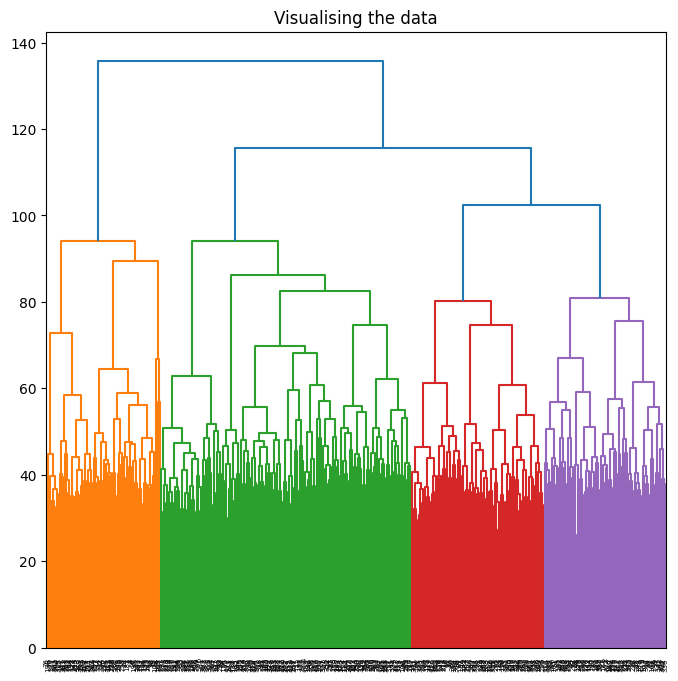

In [3]:
# Dendrogram
plt.figure(figsize =(8, 8)) 
plt.title('Visualising the data') 
Dendrogram = shc.dendrogram((shc.linkage(trnNorm, method ='ward')))

[2, 3, 4, 5, 6]


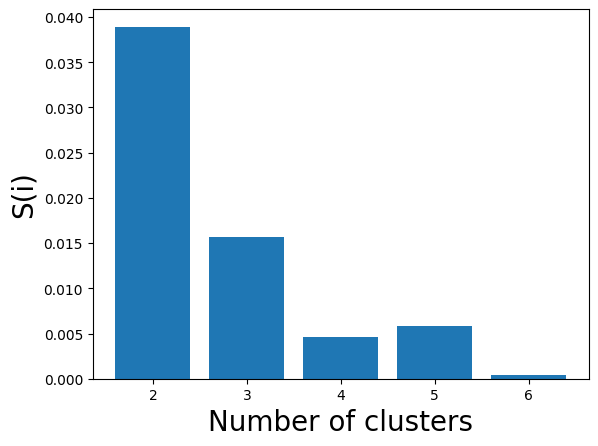

In [4]:
# Use silhouette scores to assess the best AC
# (AgglomerativeClustering) n_clusters value
kVals:list[int] = [i for i in range(2, 7)]
print(kVals)

silhScores:list = [
    silhouette_score(
        trnNorm,
        AgglomerativeClustering(n_clusters=i).fit_predict(trnNorm)
    ) for i in kVals
]

# Plotting a bar graph to compare the results 
plt.bar(kVals, silhScores) 
plt.xlabel('Number of clusters', fontsize = 20) 
plt.ylabel('S(i)', fontsize = 20) 
plt.show()

In [ ]:
# Calculate labels using optimal AC clusters
bestAC:AgglomerativeClustering = AgglomerativeClustering(n_clusters=2)
trnLabels = bestAC.fit_predict(trnNorm)
trnDF["cluster"] = trnLabels
tstLabels = bestAC.fit_predict(tstNorm)
tstDF["cluster"] = tstLabels

## Make Recomendations, Cosine Similarity, Save Model

In [ ]:
# Function to recommend top n papers (default to top_n=10)
def recommendPapers(testPaperIndex:int, top_n:int=10):
    testPaperClusters:pd.DataFrame = tstDF.iloc[
        testPaperIndex
    ]["cluster"]
    # Get all training papers in the same cluster
    sameClusterPapers:pd.DataFrame = trnDF[
        trnDF["cluster"] == testPaperClusters
    ]
    # Ensure index alignment before selecting normalized embeddings
    sameClusterIndices:pd.Index = sameClusterPapers.index.intersection(
        trnNorm.index
    )
    # Get normalized vectors (Ensure both use normalized data)
    testEmbeddings:npt.NDArray = tstNorm.iloc[
        testPaperIndex
    ].values.reshape(1, -1)
    trainEmbeddings:npt.NDArray = trnNorm.loc[
        sameClusterIndices
    ].values  # Exclude cluster column
    # Compute the distances between points
    distances:npt.NDArray = euclidean_distances(testEmbeddings, trainEmbeddings)[0]
    # Get top-N most similar papers, highest similarity first
    topIndices:npt.NDArray = np.argsort(distances)[-top_n:][::-1]
    topPapers:list[int] = sorted(sameClusterIndices[topIndices].to_list())
    topEmbeddings:npt.NDArray = trnNorm.iloc[topIndices].values
    # Compute cosine similarity
    similarities:npt.NDArray = cosine_similarity(
        testEmbeddings, topEmbeddings
    ) 
    return similarities, topPapers

# Example usage
testSims, topRecommendations = recommendPapers(0, top_n=10)
print(cleanedDF.iloc[topRecommendations])

                                                 title                link  \
17   Vehicle-to-Grid Aggregator to Support Power Gr...  /document/8930487/   
38   System Dynamics Modeling and Simulation of Ent...  /document/9620037/   
138  Linear Quadratic Tracking With Reinforcement L...  /document/9645562/   
166  Bi-Level Programming Model and Algorithm for V...  /document/8935202/   
207  An Interpretation of Long Short-Term Memory Re...  /document/9729726/   
230  Development of Serious Games for Teaching Info...  /document/8911357/   
232  Robust Deep Learning-Based Driver Distraction ...  /document/9641850/   
263  Sparse Graph Learning Under Laplacian-Related ...  /document/9606894/   
264  Investigation of DNN-HMM and Lattice Free Maxi...  /document/9623557/   
278  New Overcurrent Relay Coordination Method Thro...  /document/9648208/   

     year                                            authors  citations  \
17   2019                  ['Sid-Ali Amamra', 'James Marco']      

In [7]:
# Print out cosine similarity score matrix:
print(testSims)

# Compute average similarity score per test sample
avgTestScore:npt.NDArray = testSims.mean(axis=1)

# Overall similarity score
avgTestSim:npt.NDArray = avgTestScore.mean()
print(f"\nAverage Cosine Similarity Score for Test Set: {avgTestSim}")

# Save the trained model
joblib.dump(bestAC, "./dump/acModel.pkl")

[[ 0.06132113  0.12884481 -0.00516086 -0.01948245  0.06915453 -0.00358787
  -0.01555405 -0.05882159  0.06163077 -0.01536744]]

Average Cosine Similarity Score for Test Set: 0.020297697771740987


['./dump/acModel.pkl']

In [8]:
# Reload the model
loadedModel:AgglomerativeClustering = joblib.load("./dump/acModel.pkl")
valLabels = loadedModel.fit_predict(valNorm)
valDF["cluster"] = valLabels

In [ ]:
# Function to recommend top n papers (default to top_n=10)
def selectPapers(valPaperIndex:int, top_n:int=10):
    valPaperClusters:pd.DataFrame = valDF.iloc[
        valPaperIndex
    ]["cluster"]
    # Get all training papers in the same cluster
    sameClusterPapers:pd.DataFrame = trnDF[
        trnDF["cluster"] == valPaperClusters
    ]
    # Ensure index alignment before selecting normalized embeddings
    sameClusterIndices:pd.Index = sameClusterPapers.index.intersection(
        trnNorm.index
    )
    # Get normalized vectors (Ensure both use normalized data)
    valEmbeddings:npt.NDArray = valNorm.iloc[
        valPaperIndex
    ].values.reshape(1, -1)
    trainEmbeddings:npt.NDArray = trnNorm.loc[
        sameClusterIndices
    ].values  # Exclude cluster column
    # Compute the distances between points
    distances:npt.NDArray = euclidean_distances(valEmbeddings, trainEmbeddings)[0]
    # Get top-N most similar papers, highest similarity first
    topIndices:npt.NDArray = np.argsort(distances)[-top_n:][::-1]
    topPapers:list[int] = sorted(sameClusterIndices[topIndices].to_list())
    topEmbeddings:npt.NDArray = trnNorm.iloc[topIndices].values
    # Compute cosine similarity
    similarities:npt.NDArray = cosine_similarity(
        valEmbeddings, topEmbeddings
    ) 
    return similarities, topPapers

# Test on new papers
valSims, topSelections = selectPapers(0, top_n=10)
print(cleanedDF.iloc[topSelections])

                                                 title                link  \
3    Electromagnetic Vibration Characteristics Anal...  /document/8918234/   
8    Sub-6 GHz Highly Isolated Wideband MIMO Antenn...  /document/9709315/   
35   Recurrent NEAT Assisted 2D-DOA Estimation With...  /document/9690103/   
106  Enhanced Remote Areas Communications: The Miss...  /document/9279219/   
116  Correction to “A Novel Unbalance Compensation ...  /document/8924965/   
164  Pollution Flashover Voltage of Transmission Li...  /document/9682690/   
186  Adjacent Channel Compatibility Evaluation and ...  /document/9269338/   
221  IEEE Access Special Section Editorial: Recent ...  /document/8945464/   
276  In-situ Measurement Methodology for the Assess...  /document/8937514/   
316  Trajectory Tracking With Constrained Sensors a...  /document/8936430/   

     year                                            authors  citations  \
3    2019  ['Defeng Kong', 'Zhijun Shuai', 'Wanyou Li', '...      

In [10]:
# Print out cosine similarity score matrix
print(valSims)

# Compute average similarity score per validation sample
avgValScore:npt.NDArray = valSims.mean(axis=1)

# Overall similarity score
avgValSim:npt.NDArray = avgValScore.mean()
print(f"\nAverage Cosine Similarity Score for Validation Set: {avgValSim}")

[[-0.0482061  -0.08969062  0.15623955  0.17546877 -0.00300802  0.16803872
  -0.01254415 -0.05926356 -0.10414731 -0.05758   ]]

Average Cosine Similarity Score for Validation Set: 0.012530729209371367


## TF-IDF and Feature Importance Plot

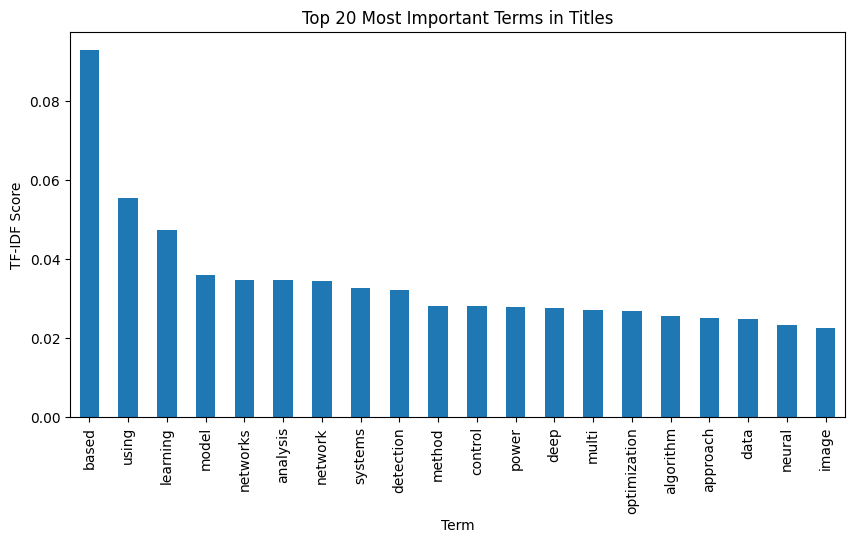

In [11]:
# Convert titles into TF-IDF representation
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
tfidf_matrix = vectorizer.fit_transform(cleanedDF["title"])

# Convert to DataFrame
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out()
)

# Plot top 20 TF-IDF terms
tfidf_df.mean().nlargest(20).plot(kind='bar', figsize=(10, 5))
plt.title("Top 20 Most Important Terms in Titles")
plt.xlabel("Term")
plt.ylabel("TF-IDF Score")
plt.show()